# Predict female behav vars from surrogate single-neuron activity

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from disp import set_plot
from my_torch import skl_fit_lin_single

cc = np.concatenate

# STRAINS = ['NM91', 'ZH23']
# STRAINS = ['CM07', 'CSTul', 'N30', 'ZW109']
STRAINS = ['NM91', 'ZH23', 'CM07', 'CSTul', 'N30', 'ZW109']
# STRAINS = ['WTG']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

SONG_HEURS = [
    'N_S_ONSETS',
    'N_P_ONSETS',
    'N_B_ONSETS',
    'S_TOTAL',
    'P_TOTAL',
    'B_TOTAL',
    # duration/ratio vars are undefined at many timepoints, which significantly changes the dataset used for fitting
#     'MN_S_DUR',
#     'MN_P_DUR',  
#     'MN_B_DUR',
#     'SP_RATIO',
]
WDWS_HEUR = [1, 10, 30, 60, 120, 1800]

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
PFX_NRL = f'data/simple/mlv/heuristic/heuristics/heuristics'

COLS_USE = ['T'] + sum([[f'{kheur}_{wdw}' for wdw in WDWS_HEUR] for kheur in SONG_HEURS], [])

FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy'

In [4]:
# fit model
rslt = skl_fit_lin_single(
    pfxs=[PFX_NRL, PFX_BHV],
    cols_x=COLS_USE,
    targs=TARGS,
    itr_all=ISTRAIN,
    ntrain=NTRAIN,
    nsplit=NSPLIT)

# save results
save_data = {
    'r2_train': rslt.r2_train,
    'r2_test': rslt.r2_test,

    'w': rslt.w,
    'bias': rslt.bias,

    'targs': TARGS,
    'heurs': COLS_USE,

    'ntr': NTR,
    'ntrain': NTRAIN,
    'nsplit': NSPLIT
}

np.save(FSAVE, np.array([save_data]))


Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

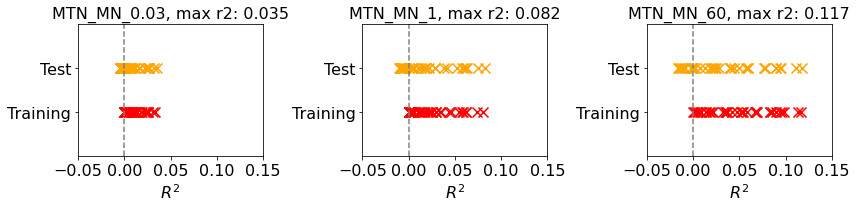

In [5]:
data = np.load(FSAVE, allow_pickle=True)[0]

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)

for ax, targ, in zip(axs, TARGS):

    r2_train = data['r2_train'][targ].mean(axis=0)  # avg over splits
    r2_test = data['r2_test'][targ].mean(axis=0)  
    r2_test_max = np.max(r2_test)

    ax.scatter(r2_train, np.zeros(len(r2_train)), c='r', marker='x', s=100)
    ax.scatter(r2_test, np.ones(len(r2_test)), c='orange', marker='x', s=100)

    ax.axvline(0, color='gray', ls='--')

    set_plot(
        ax, x_lim=(-.05, .15), y_lim=(-1, 2), y_ticks=[0, 1], 
        y_tick_labels=['Training', 'Test'], x_label=r'$R^2$', title=f'{targ}, max r2: {r2_test_max:.3f}', font_size=16)